By Amanda Nurul Izzah

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from math import sqrt

# Data Ingestion

In [ ]:
customer_full = pd.read_csv('Case Study - Customer.csv', delimiter=';')
product_full = pd.read_csv('Case Study - Product.csv', delimiter=';')
store_full = pd.read_csv('Case Study - Store.csv', delimiter=';')
transaction_full = pd.read_csv('Case Study - Transaction.csv', delimiter=';')

# Data Cleaning

## Customer

Data profiling

In [ ]:
print(customer_full.isna().sum())

customer_full.info()

customer_full.describe()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


,CustomerID,Age,Gender
count,447.000000,447.000000,447.000000
mean,224.000000,39.782998,0.458613
std,129.182042,12.848719,0.498842
min,1.000000,0.000000,0.000000
25%,112.500000,30.000000,0.000000
50%,224.000000,39.000000,0.000000
75%,335.500000,50.500000,1.000000
max,447.000000,72.000000,1.000000


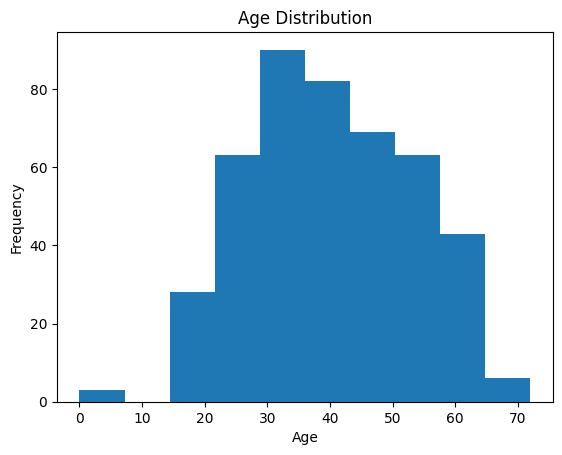

In [ ]:
plt.hist(customer_full['Age'], bins=10)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Handling missing values:

only around 0.67% of the data is lost from dropping rows with missing values so it is a sensible option.

In [ ]:
customer_full = customer_full.dropna(subset=['Marital Status'])

Data type adjustments

In [ ]:
customer_full['Income'] = customer_full['Income'].astype(str).str.replace(",", ".")

customer_full = customer_full.astype({
        'Marital Status' : 'category',
        'Income' : 'float'
        })

<ipython-input-9-149b34f06589>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_full['Income'] = customer_full['Income'].astype(str).str.replace(",", ".")


## Product

Data profiling

In [ ]:
print(product_full.isna().sum())

product_full.info()

product_full.describe()

ProductID       0
Product Name    0
Price           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


,Price
count,10.000000
mean,10410.000000
std,4890.455557
min,3200.000000
25%,7825.000000
50%,9700.000000
75%,14250.000000
max,18000.000000


No missing values

No data type adjustments needed

## Store

In [ ]:
print(store_full.isna().sum())

store_full.info()

store_full.describe()

StoreID       0
StoreName     0
GroupStore    0
Type          0
Latitude      0
Longitude     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes


,StoreID
count,14.0000
mean,7.5000
std,4.1833
min,1.0000
25%,4.2500
50%,7.5000
75%,10.7500
max,14.0000


No missing values

Data type adjustments

In [ ]:
store_full['Latitude'] = store_full['Latitude'].astype(str).str.replace(",", ".")
store_full['Longitude'] = store_full['Longitude'].astype(str).str.replace(",", ".")

store_full = store_full.astype({
        'Type' : 'category',
        'Latitude'  : 'double',
        'Longitude'  : 'double'
        })

## Transaction

In [ ]:
print(transaction_full.isna().sum())

transaction_full.info()

transaction_full.describe()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


,CustomerID,Price,Qty,TotalAmount,StoreID
count,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000
mean,221.263745,9684.800797,3.644622,32279.482072,7.489841
std,129.672955,4600.708780,1.855295,19675.462455,4.028502
min,1.000000,3200.000000,1.000000,7500.000000,1.000000
25%,108.000000,4200.000000,2.000000,16000.000000,4.000000
50%,221.000000,9400.000000,3.000000,28200.000000,7.000000
75%,332.000000,15000.000000,5.000000,47000.000000,11.000000
max,447.000000,18000.000000,10.000000,88000.000000,14.000000


No missing values

Data type adjustments

In [ ]:
transaction_full['Date'] = pd.to_datetime(transaction_full['Date'], format='%d/%m/%Y')

# Merge Data

In [ ]:
# drop duplicate columns
product_full = product_full.drop(['Price'], axis=1)

In [ ]:
full = transaction_full.merge(customer_full, how='left', on='CustomerID')
full = full.merge(product_full, how='left', on='ProductID')
full = full.merge(store_full, how='left', on='StoreID')

full.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36.0,0.0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,44.0,1.0,Married,14.58,Yoghurt,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,27.0,1.0,Single,0.18,Choco Bar,Gita Ginara,Gita,General Trade,-6.966667,110.416664
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,48.0,1.0,Married,12.57,Choco Bar,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,33.0,0.0,Married,6.95,Yoghurt,Gita Ginara,Gita,General Trade,-6.966667,110.416664


# Feature Engineering

For regression:

sum of quantity sold for each day

In [ ]:
reg_df = full.groupby('Date')['Qty'].sum().reset_index()

For clustering

In [ ]:
cluster_df = full.groupby('CustomerID').agg({
              'TransactionID': 'count',
              'Qty': 'sum',
              'TotalAmount': 'sum'
              }).reset_index()

cluster_df.set_index('CustomerID', inplace=True)

# Regression

## Train-Test Split

In [ ]:
train, test = train_test_split(reg_df, test_size=0.33, shuffle=False)

history = train.copy()
train = train.set_index('Date')
test = test.set_index('Date')

## Model Fitting (ARIMA)


In [ ]:
train_values = train['Qty']
model = ARIMA(train_values, order=(40, 2, 1))
model = model.fit()

## Getting Predictions

In [ ]:
preds = model.get_forecast(len(test)).conf_int()
preds = model.predict(start=preds.index[0], end=preds.index[-1])
preds.index = test.index

## Model Evaluation

In [ ]:
rmse = sqrt(mean_squared_error(test, preds))
print('RMSE: %.3f' % rmse)

RMSE: 15.670


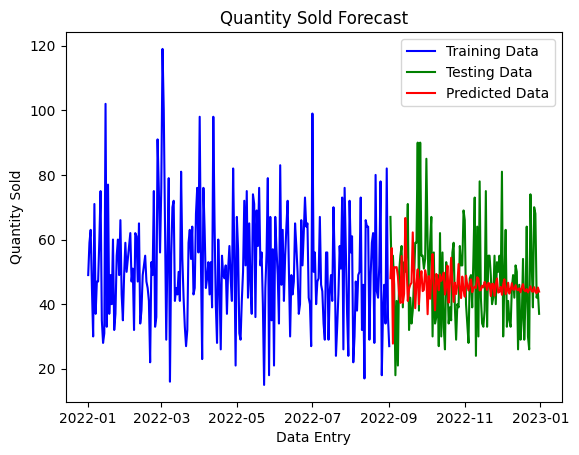

In [ ]:
# visualize performance
plt.plot(train.index, train, color='b', linestyle='-', label='Training Data')
plt.plot(test.index, test, color='g',linestyle='-', label = 'Testing Data')
plt.plot(preds, color='r', linestyle='-', label = 'Predicted Data')
plt.xlabel('Data Entry')
plt.ylabel('Quantity Sold')
plt.legend()
plt.title('Quantity Sold Forecast')
plt.show()

In [ ]:
# get average quantity sold
mean_qty = preds.mean().round()
print(mean_qty)

46.0


## Getting Forecast per Product

In [ ]:
unique_products = full['Product Name'].unique()
preds_by_product = pd.DataFrame()

# loop to get forecasts for each product
for product_name in unique_products:
    product_data = full[full['Product Name'] == product_name]

    product_data['Date'] = pd.to_datetime(product_data['Date'])
    product_data.set_index('Date', inplace=True)
    product_data = product_data.resample('D').sum().fillna(0)

    # fit model and get forecasts
    model = ARIMA(product_data['Qty'], order=(40, 2, 1))
    model_fit = model.fit()
    forecast_steps = test.shape[0]
    forecast = model_fit.get_forecast(steps=forecast_steps)

    # add forecasted values to dataframe
    forecast_mean = forecast.predicted_mean
    preds_by_product[product_name] = forecast_mean


In [ ]:
# get the average units sold for each product
product_avg_qty = preds_by_product.mean().round()
print(product_avg_qty)

Crackers         6.0
Yoghurt          4.0
Choco Bar        4.0
Cheese Stick     6.0
Oat              2.0
Thai Tea         6.0
Coffee Candy     6.0
Potato Chip      4.0
Ginger Candy     6.0
Cashew           2.0
dtype: float64


## Results and Prescription

As calculated before, going into 2023, the model forecasts a total average of **46 units/day** with daily quantities sold for each product as follows:
- Crackers: 6 units
- Yoghurt: 4 units
- Choco Bar: 4 units
- Cheese Stick: 6 units
- Oat: 2 units
- Thai Tea: 6 units
- Coffee Candy: 6 units
- Potato Chip: 4 units
- Ginger Candy : 6 units
- Cashew: 2 units

The above data could be used as a guide to meet demands when stocking inventory. Moving forward, these predictions should be tested against actual sales and be adjusted accordingly to optimize sales and reduce waste.


# Clustering

## Finding Optimum Number of Clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

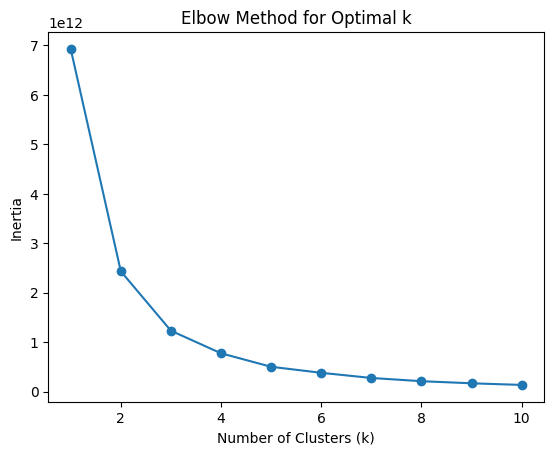

In [ ]:
inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(cluster_df)
    inertia_values.append(kmeans.inertia_)

# plot the inertia values
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

chosen number of clusters = 4

## Cluster Identification

In [ ]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(cluster_df)

cluster_assignments = kmeans.labels_

print("Cluster Assignments:", cluster_assignments)

Cluster Assignments: [2 0 0 1 1 0 0 2 1 0 3 2 2 0 0 0 1 0 2 2 1 0 0 0 3 3 1 1 0 1 1 1 3 0 3 1 2
 1 0 1 3 0 2 2 2 0 2 1 1 3 0 1 1 0 1 3 0 0 3 0 3 0 2 1 3 0 0 3 1 1 1 2 0 3
 1 0 0 3 3 1 1 0 0 0 0 1 0 2 2 1 1 1 0 1 0 1 1 1 1 1 0 0 1 3 2 2 2 0 1 3 3
 2 3 0 0 0 1 0 0 0 0 1 1 0 3 3 2 1 0 1 0 0 2 0 0 1 0 0 1 1 1 1 3 3 3 3 0 3
 0 0 1 0 3 1 0 2 2 0 1 0 1 1 1 1 1 2 2 1 1 3 2 2 1 0 1 3 1 0 3 3 1 1 1 2 3
 1 0 1 2 0 1 3 3 3 0 1 1 0 0 3 1 1 0 0 3 0 1 3 1 2 1 1 0 1 1 1 0 0 2 1 1 0
 0 1 1 0 3 1 0 3 0 1 2 0 0 1 0 1 0 2 1 3 0 1 2 0 0 1 1 1 1 1 1 1 3 0 1 1 3
 2 3 3 2 0 3 1 0 0 1 2 1 0 0 3 1 0 2 0 0 0 0 0 0 0 1 3 1 1 0 3 3 3 1 3 0 1
 1 0 2 3 2 1 2 0 1 0 1 1 3 0 0 1 3 1 0 3 1 3 0 3 2 1 3 3 3 2 1 3 2 1 1 3 3
 3 1 0 3 1 0 0 0 0 1 3 1 3 0 0 3 1 1 1 1 1 1 2 0 0 3 1 1 0 1 0 2 0 3 1 0 2
 3 1 1 0 1 0 1 0 1 1 3 3 3 2 3 1 3 3 3 3 0 2 0 1 1 1 3 1 1 3 0 3 1 0 3 3 3
 0 0 3 3 3 0 0 1 2 2 3 3 3 1 2 2 0 3 3 2 1 1 0 1 3 1 2 0 1 3 0 3 0 3 1 0 2
 2 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


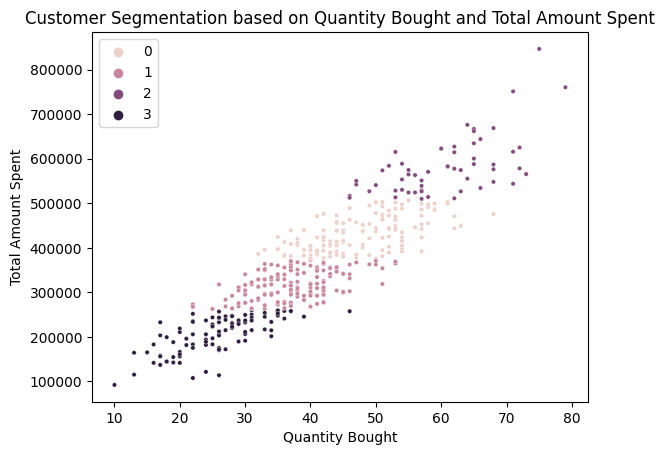

In [ ]:
# visualize cluster
sns.scatterplot(x=cluster_df['Qty'], y=cluster_df['TotalAmount'], s=10, hue=cluster_assignments)
plt.xlabel('Quantity Bought')
plt.ylabel('Total Amount Spent')
plt.title('Customer Segmentation based on Quantity Bought and Total Amount Spent')
plt.legend()
plt.show()

## Model Evaluation

In [ ]:
silhouette_avg = silhouette_score(cluster_df, cluster_assignments)
print(f"Silhouette Score: {silhouette_avg:.2f}")

Silhouette Score: 0.52


## Results and Prescription



Analyzing the four clusters above presents us with some insight into the customers' spending patterns. Tailored to each cluster's characteristics, here are some possible marketing strategies that can be implemented.



**Cluster 0: Upper-medium Spenders**

Customers in Cluster 1 spend a lot but have not yet reached the high spender category. We want to engage Cluster 1 more, as they have the potential to transition into high spenders. Here are a few ways how:
- Upsell and suggest higher-value items related to their usual purchases
- Offer premium services from time to time
- Introduce a point system that brings values if they shop in a higher bracket

**Cluster 1: Lower-medium Spenders**

Customers in Cluster 3 spend more than Cluster 0, but still need more encouragement to increase their spending. To increase engagement, try:
- Offering bundles to introduce new products
- Providing limited-time offers to increase urgency
- Showing educational content on products they might take an interest in

**Cluster 2:  High Spenders**

Customers in Cluster 2 spend a lot and buy a lot. We want to keep these premium customers as engaged, if not more. A few possible strategies to retain this cluster are:
- Providing exclusive loyalty discounts and bundles
- Providing early access to new products or services
- Prioritized customer service

**Cluster 3: Low Spenders**

Customers in Cluster 0 are typically value-conscious and only shop occasionally. We want to incentivize Cluster 0 to shop more frequently. This can be done by:
- Providing welcome-back offers
- Implementing a loyalty card that offers incremental discounts the more they purchase
- Regularly curating a selection of items to pique their interest
